## Using LightGBM

In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMClassifier
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

In [ ]:
cancer_df = pd.DataFrame(data= dataset.data, columns = dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

In [ ]:
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(X_features,y_label, test_size=0.2)
X_tr, X_val, y_tr, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state = 10)
model = LGBMClassifier(n_estimators=400, learning_rate=0.05)
evals = [(X_tr,y_tr),(X_val,y_val)]
model.fit(X_tr, y_tr, eval_metric='logloss',
          eval_set=evals)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

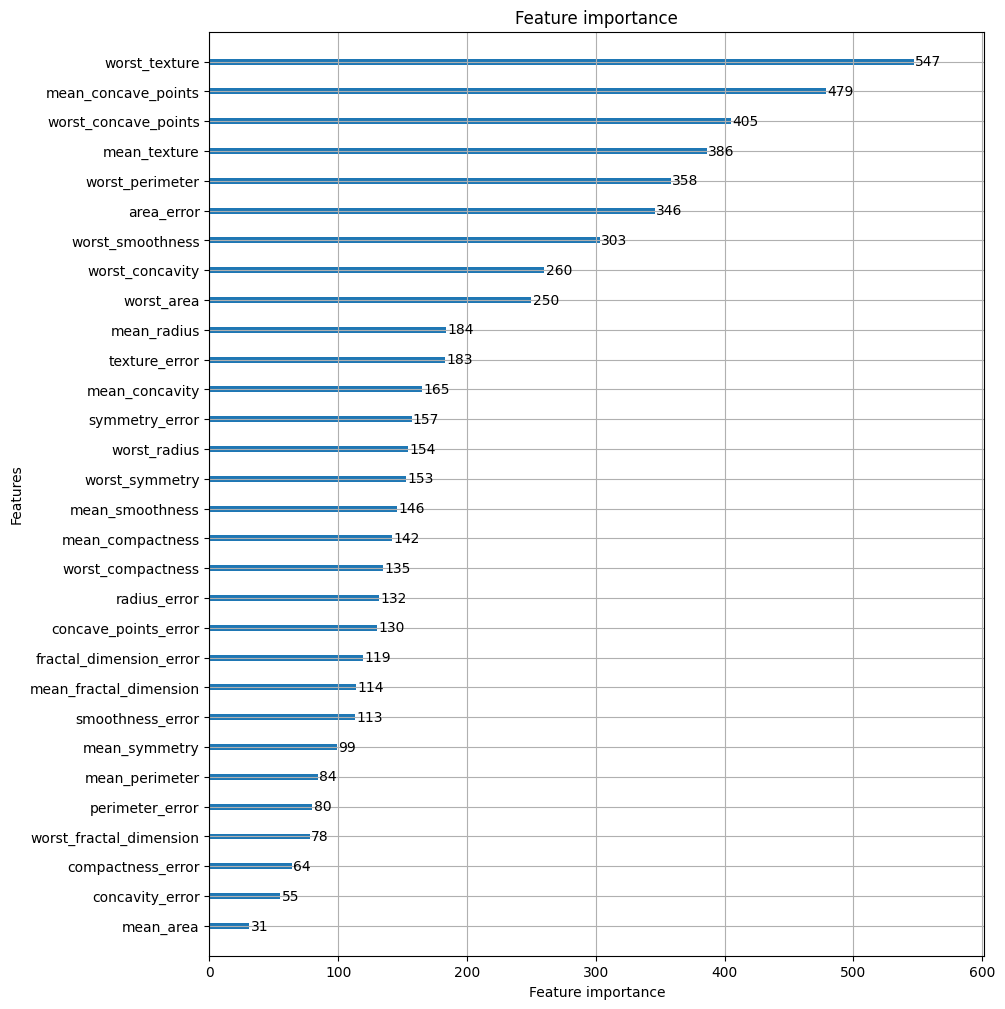

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax =plt.subplots(figsize =(10,12))
plot_importance(model, ax = ax)

## HyperOpt

find Parameters effectively

In [ ]:
!pip install hyperopt

In [ ]:
# 1. 입력 변수 및 입력값 검색공간 설정
# 2. 목적함수의 설정
# 3. 목적함수 반환 최솟값 --> 최적 입력값

#1
from hyperopt import hp
# labeling
search_space = {'x':hp.quniform('x',-10,10,1), 'y': hp.quniform('y',-15, 15, 1)}

In [ ]:
# 2
from hyperopt import STATUS_OK

def objective_func(search_space):
  x = search_space['x']
  y = search_space['y']
  # return Value
  retval = x**2 - 20*y
  return retval

  # using fmin(objective, space, algo, max_evals, trials)

In [ ]:
# 3
from hyperopt import fmin, tpe, Trials
import numpy as np
trial_val = Trials()

best_01 = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 5,
               trials = trial_val, rstate = np.random.default_rng(seed = 0))

100%|██████████| 5/5 [00:00<00:00, 97.23trial/s, best loss: -224.0]


In [ ]:
# 20번 수행

trial_val = Trials()

best_02  = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 20,
               trials = trial_val, rstate = np.random.default_rng(seed = 0))

100%|██████████| 20/20 [00:00<00:00, 396.13trial/s, best loss: -296.0]


In [ ]:
print(best_01)
print(best_02)

#  651 -> 20 으로 search 횟수를 줄인다

{'x': -4.0, 'y': 12.0}
{'x': 2.0, 'y': 15.0}


In [ ]:
import pandas as pd

losses = [loss_dict['loss'] for loss_dict in trial_val.results]

# 값 설정
result_df =pd.DataFrame({'x': trial_val.vals['x'], 'y': trial_val.vals['y'], 'losses':losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


# Using HyperOpt from XGBoost

In [ ]:
# hyperopt는 실수값만 받기 때문에 파라미터 입력시 형 변환
# 성능값이 클수록 좋은 성능 지표  -> 값을 최솟값 반환하도록 설정
# 즉 -1을 곱해서 최적화

xgb_search_space = {'max_depth':hp.quniform('max_depth',5,20,1),
                    'min_child_weight': hp.quniform('min_child_weight',1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate',0.01,0.2),
                    'colsample_bytree':hp.uniform('colsample_bytree',0.5,1)}

max_depth와 같이 실수값이 형 변환

즉 정수값으로 형변환 해서 하이퍼 파라미터로 입력

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            learning_rate=search_space['learning_rate'],
                            colsample_bytree=search_space['colsample_bytree'],
                            eval_metric='logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)

    # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
    return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [ ]:
from hyperopt import fmin, tpe, Trials
trial_val = Trials()
# 50번만 실행한다
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trial_val, rstate=np.random.default_rng(seed=9))
print('best:', best)

100%|██████████| 50/50 [00:21<00:00,  2.38trial/s, best loss: -0.951681770651795]
best: {'colsample_bytree': 0.7929291286054244, 'learning_rate': 0.18562883317114579, 'max_depth': 20.0, 'min_child_weight': 2.0}


In [ ]:
# 도출된 최적 하이퍼 파라미터로 XGBClassifier 재학습
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]



### 캐글 산탄데르 고객 만족 예측